In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

In [ ]:
dataset_path = ("/content/drive/MyDrive/project /EXTRACT_IMAGES")

In [ ]:
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["GOLF","KICKING_FRONT", "KICKING_SIDE", "LIFTING", "RIDING_HORSE", "RUN_SIDE", "SKATEBOARD", "SWING_BENCH", "WALKFRONT"])
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue
	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:

baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs= 20)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
15/15 [==============================] - 103s 7s/step - loss: 2.6351 - accuracy: 0.1672 - val_loss: 1.9240 - val_accuracy: 0.3688
Epoch 2/20
15/15 [==============================] - 98s 7s/step - loss: 2.0169 - accuracy: 0.3002 - val_loss: 1.2917 - val_accuracy: 0.4938
Epoch 3/20
15/15 [==============================] - 99s 7s/step - loss: 1.4226 - accuracy: 0.4977 - val_loss: 0.8527 - val_accuracy: 0.8625
Epoch 4/20
15/15 [==============================] - 98s 7s/step - loss: 0.9430 - accuracy: 0.6991 - val_loss: 0.6306 - val_accuracy: 0.9500
Epoch 5/20
15/15 [==============================] - 99s 7s/step - loss: 0.7259 - accuracy: 0.8070 - val_loss: 0.4744 - val_accuracy: 0.9812
Epoch 6/20
15/15 [==============================] - 99s 7s/step - loss: 0.6355 - accuracy: 0.8248 - val_loss: 0.3571 - val_accuracy: 1.0000
Epoch 7/20
15/15 [==============================] - 99s 7s/step - loss: 0.4783 - accuracy: 0.9188 - val_loss:

In [ ]:
predictions = model.predict(x=testX.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))


               precision    recall  f1-score   support

         GOLF       1.00      1.00      1.00        15
KICKING_FRONT       1.00      1.00      1.00        12
 KICKING_SIDE       1.00      1.00      1.00        13
      LIFTING       1.00      1.00      1.00        28
 RIDING_HORSE       1.00      1.00      1.00        15
     RUN_SIDE       1.00      1.00      1.00        19
   SKATEBOARD       1.00      1.00      1.00        25
  SWING_BENCH       1.00      1.00      1.00        12
    WALKFRONT       1.00      1.00      1.00        25

     accuracy                           1.00       164
    macro avg       1.00      1.00      1.00       164
 weighted avg       1.00      1.00      1.00       164



In [ ]:
#model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from keras.models import load_model

In [ ]:
model.save('resnet50.h5')

In [ ]:
import numpy as np
import PIL

In [ ]:
model = load_model('resnet50.h5')

In [ ]:
path = "/content/drive/MyDrive/project /EXTRACT_IMAGES/GOLF/7603-4_70159.jpg"

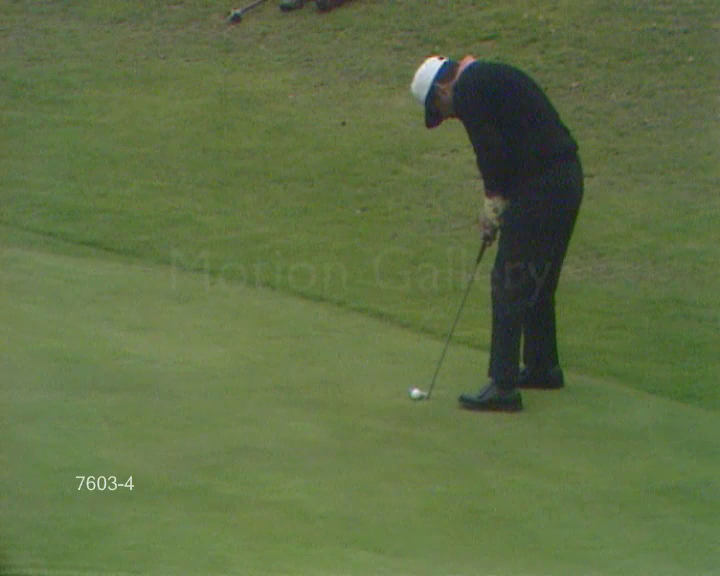

In [ ]:
tf.keras.preprocessing.image.load_img(path)
